In [3]:
import matplotlib
import sys
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz, filtfilt, argrelextrema
from data_extract_ios import pull_data

%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 5) 

Pull in data

In [4]:
filename = 'tosses_15'

x, y, z, signal, timestamps = pull_data('data', filename)

# Making timestamps start at 0
c = timestamps[0]
timestamps = (timestamps - c)

# sample_rate = 1 / timestamps[1] == 99.8
sample_rate = 100 # Hz

Graphing acelerometer x,y,z and magnitude

<IPython.core.display.Javascript object>


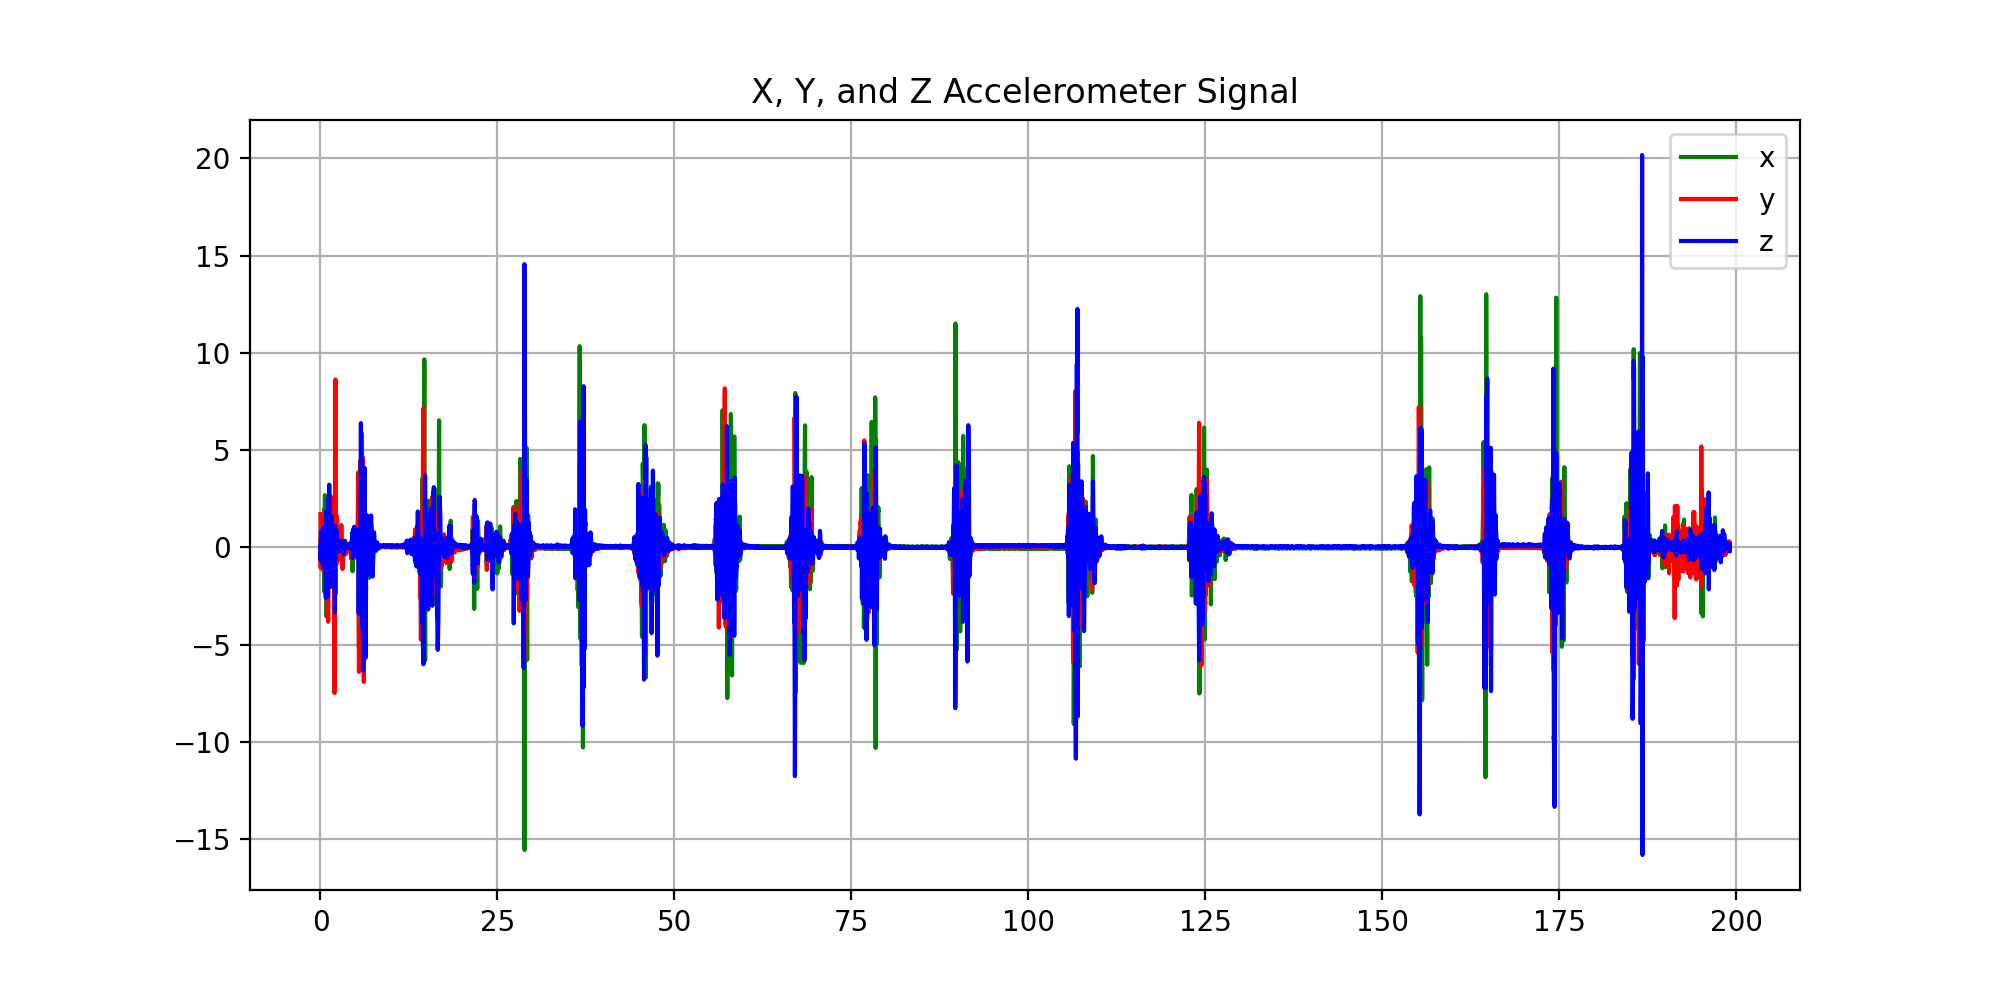

In [5]:
plt.figure(figsize=(10,5))
plt.title("X, Y, and Z Accelerometer Signal")

plt.plot(timestamps, x, 'g-',label="x")
plt.plot(timestamps, y, 'r-',label="y")
plt.plot(timestamps, z, 'b-',label="z")

plt.legend(loc = 'upper right')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


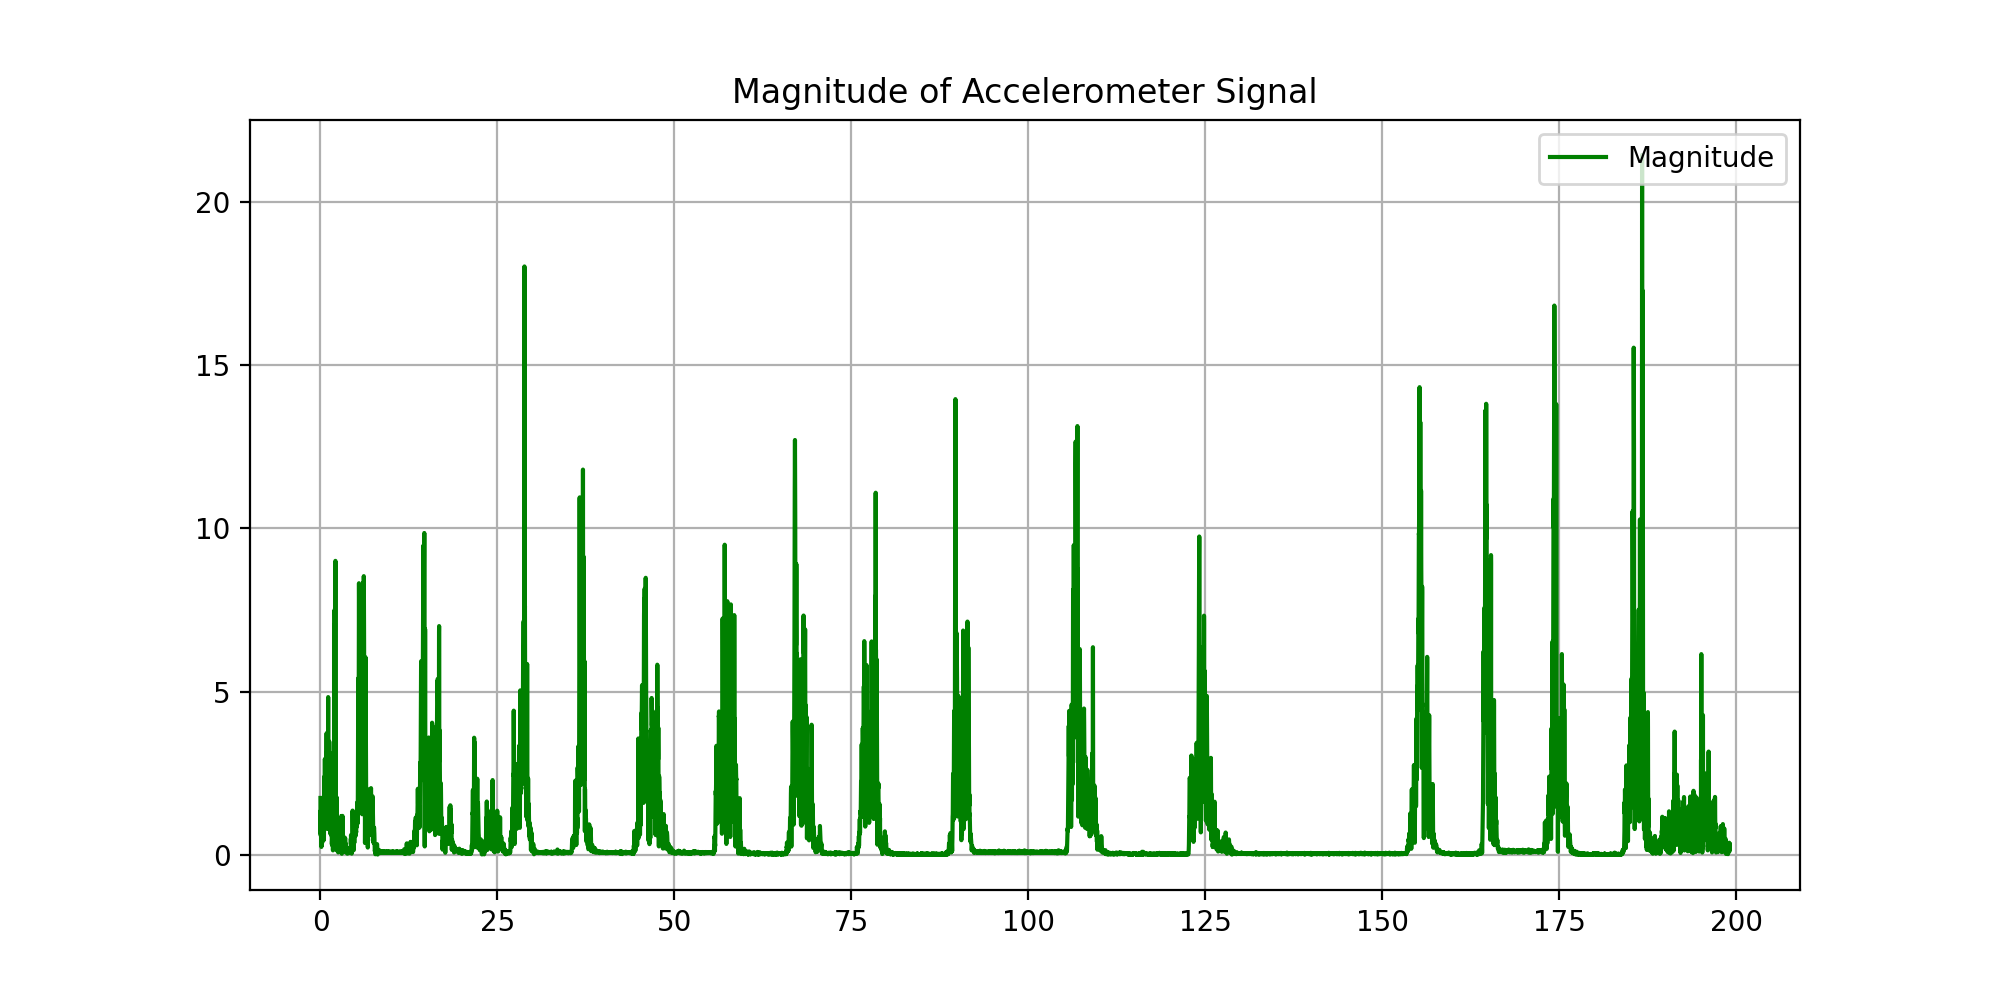

In [6]:
plt.figure(figsize=(10,5))
plt.title("Magnitude of Accelerometer Signal")

plt.plot(timestamps, signal, 'g-',label="Magnitude")

plt.legend(loc = 'upper right')
plt.grid()
plt.show()

Creating and appling filter

In [7]:
# FILL IN CODE: Create and apply Butterworth filter

# Filter requirements.
order = 3
cutoff = 5 # desired cutoff frequency of the filter, Hz

# Create the filter.
nyq = 0.5 * sample_rate
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='low', analog=False) #low pass only filter

filtered_signal = filtfilt(b, a, signal)

Graphing filtered vs unfiltered signal

In [8]:
# plt.figure(figsize=(10,5))
# plt.title("Filtered vs Unfiltered")

# plt.plot(timestamps, signal, 'b-',label="Signal")
# plt.plot(timestamps, filtered_signal, 'r-',label="Filtered")

# plt.legend(loc = 'upper right')
# plt.grid()
# plt.show()

Step counting algorithm using peaks and more filtering

In [9]:
# Finding peaks and filtering
index_of_peaks = argrelextrema(filtered_signal, np.greater)[0] #returns array of all of the indexs of peaks/local maxima in the signal
filtered_index_of_peaks = np.array([])
for i in index_of_peaks:
    peak = filtered_signal[i]
    if peak > 3: #Filters out lower magnitude peaks that would not be steps -> this number can be modified
        filtered_index_of_peaks = np.append(filtered_index_of_peaks, i)

# Peak values for graph and filteres peaks that are too close together
peaks = np.array([])
peak_times = np.array([])
for i in range(len(filtered_index_of_peaks)):
    # Filters out peaks that are too close together
    if i > 0 and filtered_index_of_peaks[i] - filtered_index_of_peaks[i-1] < 40:
        continue
    peak_index = int(filtered_index_of_peaks[i])
    peaks = np.append(peaks, filtered_signal[peak_index])
    peak_times = np.append(peak_times, timestamps[peak_index])

steps_counted = len(peaks)
print(f'peaks before filtering: {len(index_of_peaks)}')
print(f'steps counted: {steps_counted}')

peaks before filtering: 770
steps counted: 35


Graphing where steps were counted on the filtered signal graph

<IPython.core.display.Javascript object>


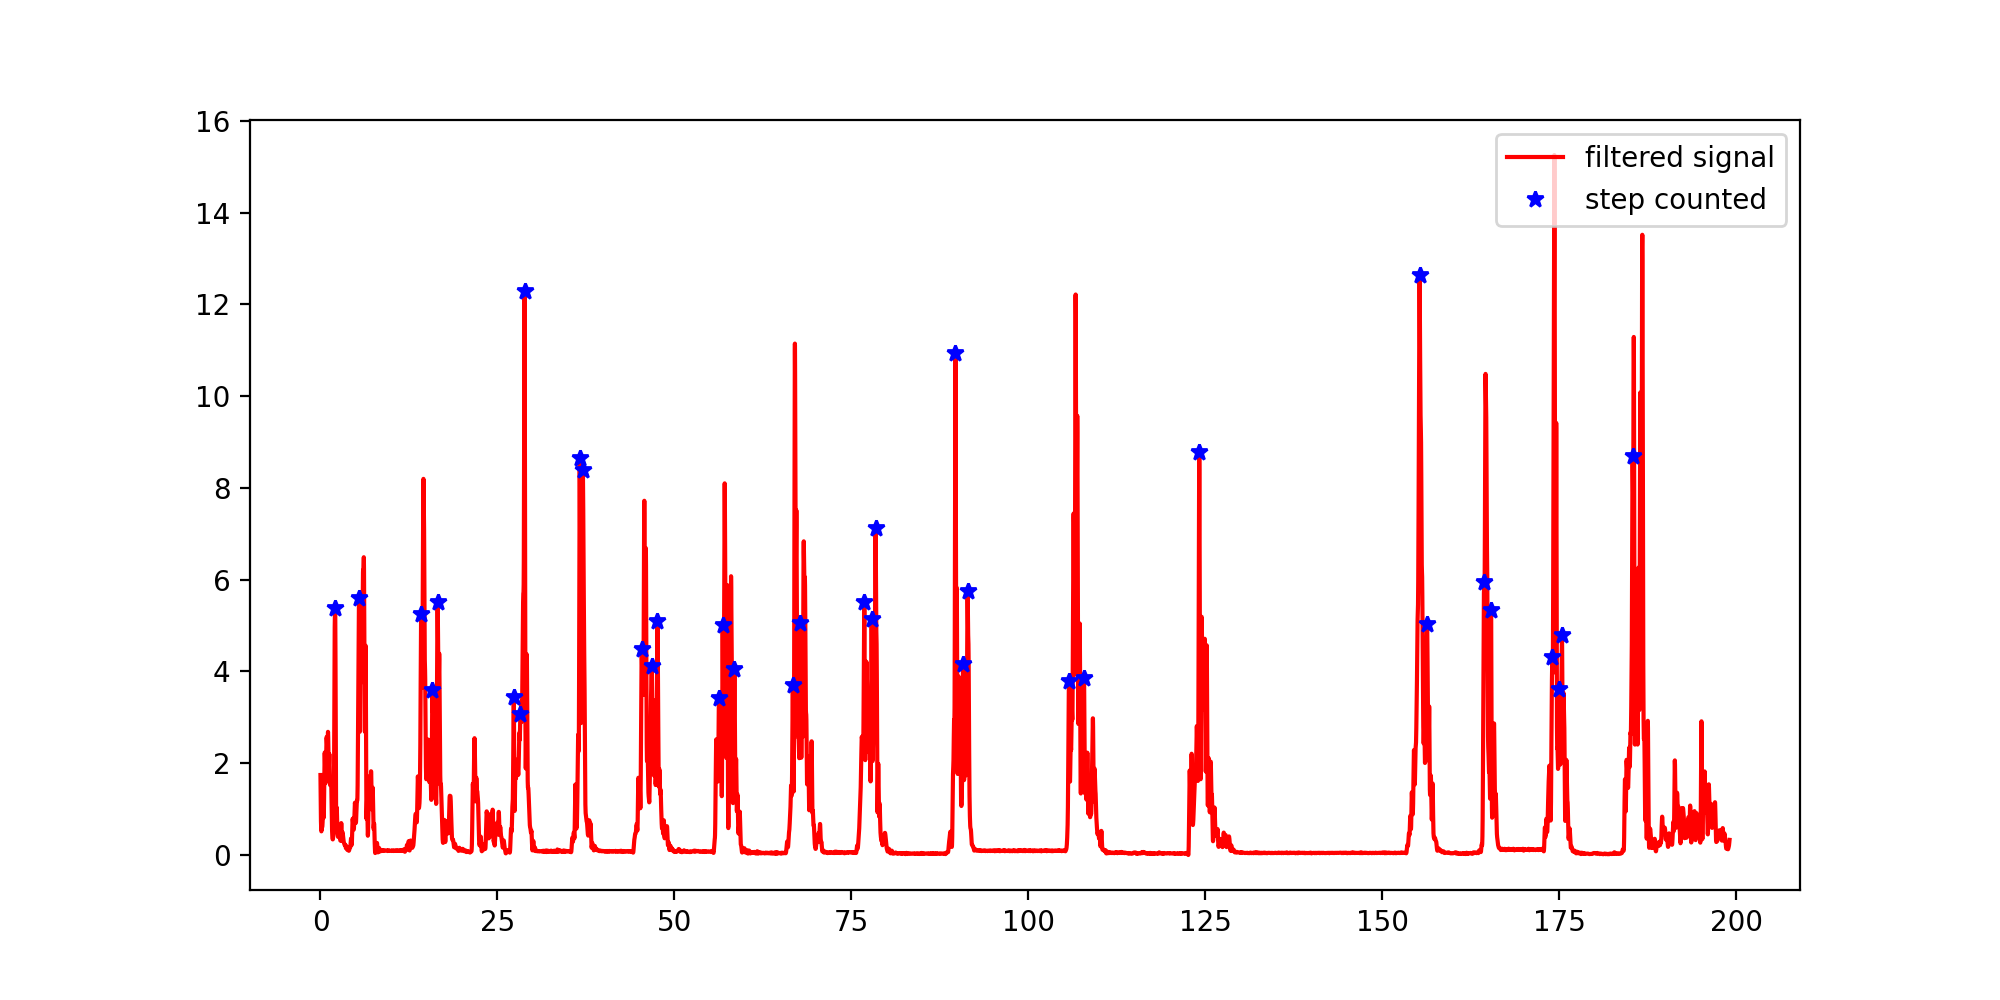

In [10]:
plt.figure()
plt.plot(timestamps, filtered_signal, "-r", label='filtered signal')
plt.plot(peak_times, peaks, "b*", label='step counted')
plt.legend(loc = 'upper right')
plt.show()

In [11]:
# Calculate % of accuracy
actual_steps = int(filename[14:16])
accuracy = 100 - ((abs(actual_steps - steps_counted) / actual_steps) * 100)
print(f'actual steps: {actual_steps}, counted steps: {steps_counted}, --> {accuracy} %')

ValueError: invalid literal for int() with base 10: ''